# Import Data - Multi-site example
In this example we see the power of scripting over Excel. Here we process all sites for a given state (NC). 

#### Import the modules used in this analysis

In [2]:
#Modules for retreiving data
import requests, io

#Modules for wrangling data
import pandas as pd
import numpy as np

#Modules for mapping
import folium

#Modules for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Enable inline plots in Jupyter
%matplotlib inline

#### Format and execute the data request URL for the NWIS API

In [120]:
#Generate a list of all sites in NC using the NWIS API 
# see https://waterservices.usgs.gov/rest/DV-Service.html
url = 'http://waterservices.usgs.gov/nwis/site'
params = {'stateCd':'NC',        #NC Sites Only
          'siteStatus':'all', #Get all *active* sites
          'siteType':'ST',       #Stream sites only
          'parameterCd':'00060', #DISCHARGE(cfs), see https://help.waterdata.usgs.gov/codes-and-parameters/parameters
          'seriesCatalogOutput':'TRUE',
          'format':'rdb'         #RDB (csv)
         }

#Send the requests and translate the response
response_raw = requests.get(url,params)

#Decode to remove any odd characters (accents, etc.)
response_clean = response_raw.content.decode('utf-8')

#### Convert the retrieved data into a data frame

In [121]:
#Build a list of line numbers to skip from comments and data types
rowsToSkip= [] #Create an empty list to hold line numbers
lineNumber = 0 #Initialize a line number variable

#Iterate through lines, adding the line number to the list for comment lines
for lineNumber, lineString in enumerate(response_clean.split("\n")):
    if lineString.startswith('#'): 
        rowsToSkip.append(lineNumber)
    else:
        break
        
#Add another line 2 greater than the last
dataTypeLineNumber = rowsToSkip[-1] + 2
rowsToSkip.append(dataTypeLineNumber)

In [153]:
#Convert the data into a data frame
df = pd.read_csv(io.StringIO(response_clean),
                 skiprows=rowsToSkip,     #Skip metadta and data spec lines
                 delimiter='\t',          #Set to tab delimited
                 dtype={'site_no':'str',  #Set site_no to a string datatype
                        'stat_cd':'str',
                        'loc_web_ds':'str',
                        'huc_cd':'str'})  #Set huc_cd to a string datatype

In [156]:
#Convert date columns to dateobjects
df['begin_date'] = pd.to_datetime(df['begin_date'],format=('%Y-%m-%d'))
df['end_date'] = pd.to_datetime(df['end_date'],format=('%Y-%m-%d'))

In [157]:
#Add a column to list days of record (end minus begin dates)
df['period_days'] = (df['end_date'] - df['begin_date']).dt.days

In [159]:
#Create filters
startMask = df.begin_date <= '1950-01-01' #Sites that started collecting data < 1950
endMask =  df.end_date >= '2010-01-01'    #Sites that continued collection data > 2010
statMask = df.stat_cd == '00003'          #Select only "mean stream flow" records              
periodMask = df.period_days > (365 * 30)  #Sites with > 30 years of data
#Apply filters
df2 = df[startMask & endMask & statMask & periodMask]
df2.site_no.nunique()

67

#### Map the results, using Lat/Lng values

In [165]:
#Find center coordinates from medians of lat and long columns
meanLat = df2['dec_lat_va'].median()
meanLng = df2['dec_long_va'].median()

#Create the initial map
m = folium.Map(location=[meanLat,meanLng],
               zoom_start=7,
               tiles='stamenterrain')

#Loop through all features and add them to the map as markers
for row in df2.itertuples():
    #Get info for the record
    lat = row.dec_lat_va
    lng = row.dec_long_va
    name = row.station_nm
    #Create the marker object, adding them to the map object
    folium.CircleMarker(location=[lat,lng],
                        popup=name,
                        color='red',
                        fill=True,
                        fill_opacity=0.6,
                        radius=5,
                        stroke=False).add_to(m)
#Show the map
m

In [166]:
#Save the file
m.save("NC_sites.html")

In [167]:
#Open in a browser
import webbrowser
webbrowser.open_new_tab("NC_sites.html")

True

## Show plots for a subset of points

In [235]:
#Subset records in Upper Neuse watershed (HUC8 = 03020201)
dfUpperNeuse = df2[df2['huc_cd'] == '03020201']

In [240]:
#List the unique site names are contained here
siteList = list(dfUpperNeuse.groupby(['site_no','station_nm']).first().index)

In [236]:
#Make a list of site numbers and names
siteNumbers = dfUpperNeuse['site_no'].unique().tolist()
siteNames = dfUpperNeuse['station_nm'].unique().tolist()
for num,name in zip(siteNumbers, siteNames):
    print(num,name)

02085000 ENO RIVER AT HILLSBOROUGH, NC
02085500 FLAT RIVER AT BAHAMA, NC
02086500 FLAT RIVER AT DAM NEAR BAHAMA, NC
02087500 NEUSE RIVER NEAR CLAYTON, NC
02088000 MIDDLE CREEK NEAR CLAYTON, NC
02088500 LITTLE RIVER NEAR PRINCETON, NC


In [241]:
for num, name in siteList:
    print(num,name)

02085000 ENO RIVER AT HILLSBOROUGH, NC
02085500 FLAT RIVER AT BAHAMA, NC
02086500 FLAT RIVER AT DAM NEAR BAHAMA, NC
02087500 NEUSE RIVER NEAR CLAYTON, NC
02088000 MIDDLE CREEK NEAR CLAYTON, NC
02088500 LITTLE RIVER NEAR PRINCETON, NC


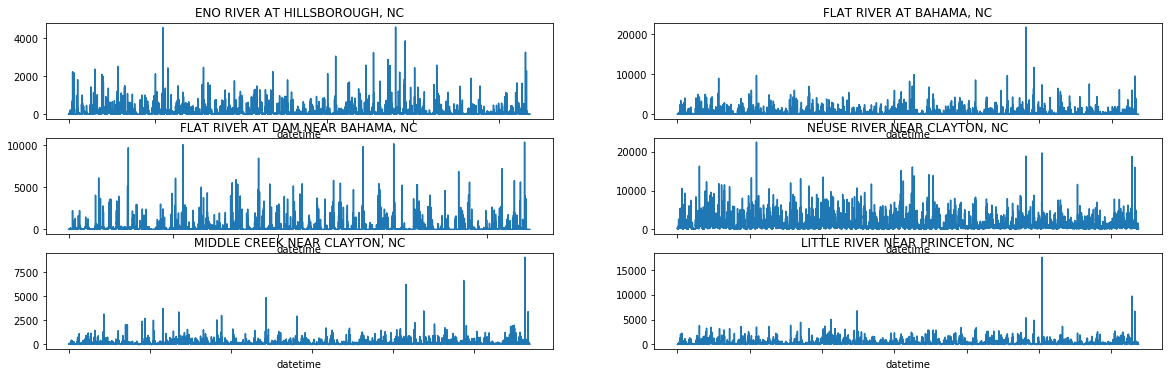

In [247]:
#Create the canvas on which to add subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,6))
axes_list = [item for sublist in axes for item in sublist] 

#Loop through each site
for siteNo, siteName in siteList:

    #Construct the service URL and parameters
    url =  'https://waterservices.usgs.gov/nwis/dv'
    params = {'sites':siteNo,
              'parameterCd':'00060',
              'statCd':'00003',
              'startDT':'1930-10-01',
              'endDT':'2017-12-31',
              'format':'rdb',
              'siteStatus':'all'
             }
    response_raw =  requests.get(url,params)
    response_clean =response_raw.content.decode('utf-8')
    
    #Convert the data into a data frame
    
    #Build a list of line numbers to skip from comments and data types
    rowsToSkip= [] #Create an empty list to hold line numbers
    lineNumber = 0 #Initialize a line number variable
    #Iterate through lines, adding the line number to the list for comment lines
    for lineNumber, lineString in enumerate(response_clean.split("\n")):
        if lineString.startswith('#'): 
            rowsToSkip.append(lineNumber)
        else:
            break
            
    #Add another line 2 greater than the last
    dataTypeLineNumber = rowsToSkip[-1] + 2
    rowsToSkip.append(dataTypeLineNumber)
    
    #Create a dataframe from the downloaded data
    dfSite = pd.read_csv(io.StringIO(response_clean),
                         skiprows=rowsToSkip,
                         delimiter='\t',
                         dtype={'site_no':'str'})

    #Rename the columns
    dfSite.columns = ['agency_cd','site_no','datetime','meanflow_cfs','confidence']
    dfSite.index= dfSite.datetime
    
    #Fix any errors
    dfSite['flow'] = pd.to_numeric(dfSite['meanflow_cfs'],errors='coerce')

    #PLOT
    ax = axes_list.pop(0)
    dfSite['flow'].plot(ax=ax)
    ax.set_title(siteName)


In [245]:
response_raw.url

'https://waterservices.usgs.gov/nwis/dv/?sites=02088000&parameterCd=00060&statCd=00003&startDT=1930-10-01&endDT=2017-12-31&format=rdb&siteStatus=all'

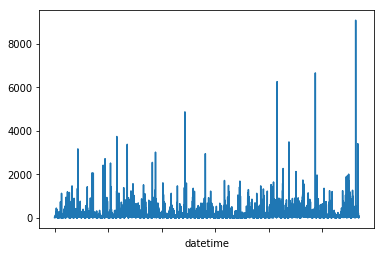

In [207]:
dfSite["x"] = pd.to_numeric(dfSite['meanflow_cfs'],errors='coerce')
dfSite["x"].plot()

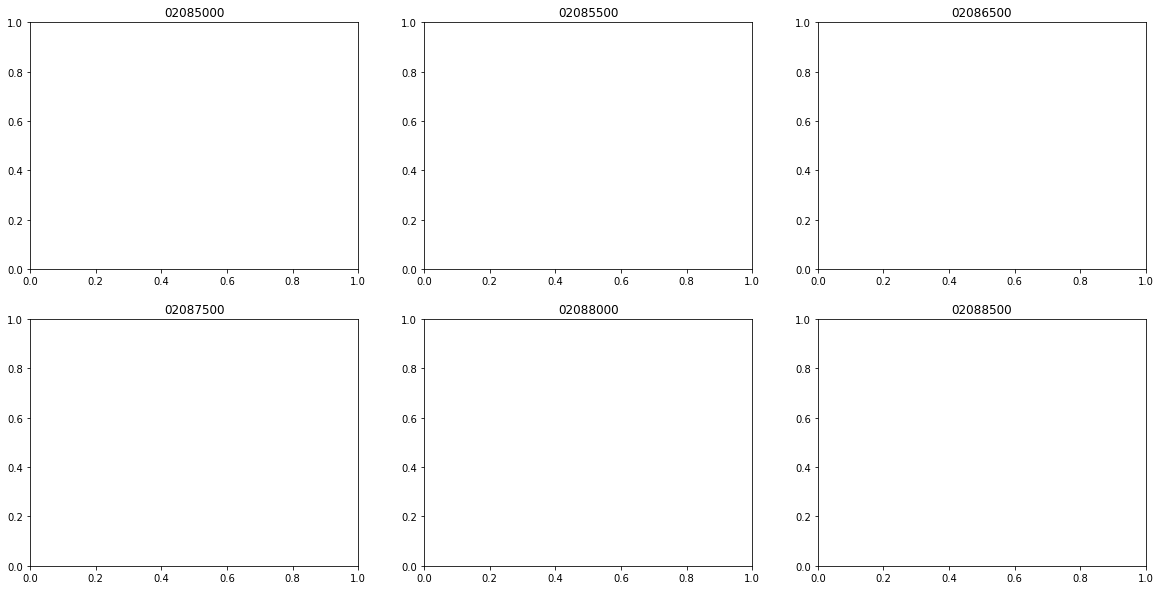

In [185]:
#Create the canvas on which to add subplots
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(10,5))
axes_list = [item for sublist in axes for item in sublist] 

#Loop through each site
for i, siteNo in enumerate(siteNumbers):
    
    #Construct the service URL and parameters
    url =  'https://waterservices.usgs.gov/nwis/dv'
    params = {'sites':siteNo,
              'parameterCd':'00060',
              'statCd':'00003',
              'startDT':'1930-10-01',
              'endDT':'2017-09-03',
              'format':'rdb',
              'siteStatus':'all'
             }
    response_raw =  requests.get(url,params)
    response_clean =response_raw.content.decode('utf-8')
    
    #Convert the data into a data frame
    
    #Build a list of line numbers to skip from comments and data types
    rowsToSkip= [] #Create an empty list to hold line numbers
    lineNumber = 0 #Initialize a line number variable
    #Iterate through lines, adding the line number to the list for comment lines
    for lineNumber, lineString in enumerate(response_clean.split("\n")):
        if lineString.startswith('#'): 
            rowsToSkip.append(lineNumber)
        else:
            break
            
    #Add another line 2 greater than the last
    dataTypeLineNumber = rowsToSkip[-1] + 2
    rowsToSkip.append(dataTypeLineNumber)
    
    #Create a dataframe from the downloaded data
    dfSite = pd.read_csv(io.StringIO(response_clean),
                         skiprows=rowsToSkip,
                         delimiter='\t',
                         dtype={'site_no':'str'})

    #Rename the columns
    dfSite.columns = ['agency_cd','site_no','datetime','meanflow_cfs','confidence']

    #plot the flow
 
    ax = plt.subplot(2,3,plotnumber)
    dfSite['meanflow_cfs'].plot #dfSite['meanflow_cfs'].plot(figsize=(20,6))
    #ax.plot(dfSite['meanflow_cfs'])
    ax.set_title(siteNo)
    
    plotnumber += 1
    
#plt.tight_layout()
#ax.plot(dfSite['meanflow_cfs'])

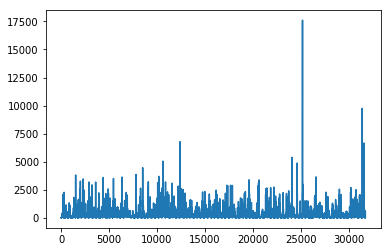

In [181]:
fig, ax = plt.subplots(2,3,1)
ax.plot(dfSite['meanflow_cfs'])